In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Load train test saved dataset

In [2]:
train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')

print("✅ Data loaded successfully")

✅ Data loaded successfully


#### Separate features and target

In [ ]:
X_train = train.drop(['trend_label', 'date'], axis=1)
y_train = train['trend_label']

X_test = test.drop(['trend_label', 'date'], axis=1)
y_test = test['trend_label']

print("Train:", X_train.shape, "| Test:", X_test.shape)

## Encoding Lags and target labels

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [4]:
model_df = pd.read_csv("modeling_dataset.csv")

In [5]:
# Cyclical encoding for temporal features
model_df['month_sin'] = np.sin(2 * np.pi * model_df['month'] / 12)
model_df['month_cos'] = np.cos(2 * np.pi * model_df['month'] / 12)
model_df['weekday_sin'] = np.sin(2 * np.pi * model_df['weekday'] / 7)
model_df['weekday_cos'] = np.cos(2 * np.pi * model_df['weekday'] / 7)

# Lag features from the target (capture recent trend)
target = "trend_label"
for i in range(1, 4):
    model_df[f'trend_lag{i}'] = model_df[target].shift(i)

# Drop the now-unused raw temporal columns
model_df.drop(['month', 'weekday'], axis=1, inplace=True)

# Drop rows with NaNs due to lag creation
model_df = model_df.dropna().reset_index(drop=True)

In [6]:
# One-hot encode categorical temporal features
model_df = pd.get_dummies(
    model_df,
    columns=['trend_lag1', 'trend_lag2', 'trend_lag3'],
    drop_first=True
)

In [7]:
model_df = model_df.sort_values("date")

split_idx = int(len(model_df) * 0.7)
train = model_df.iloc[:split_idx]
test = model_df.iloc[split_idx:]

X_train = train.drop(['trend_label', 'date'], axis=1)
y_train = train['trend_label']

X_test = test.drop(['trend_label', 'date'], axis=1)
y_test = test['trend_label']

#### Encode Label

In [9]:
label_enc = LabelEncoder()

y_train_enc = label_enc.fit_transform(y_train)
y_test_enc = label_enc.transform(y_test)

print("Label mapping:", dict(zip(label_enc.classes_, label_enc.transform(label_enc.classes_))))

Label mapping: {'Downtrend': np.int64(0), 'Sideways': np.int64(1), 'Uptrend': np.int64(2)}


In [10]:
# Recreate y_train and y_test directly from your split DataFrames
y_train = train['trend_label']
y_test  = test['trend_label']


# Check shape and unique values
print("y_train_enc shape:", y_train_enc.shape)
print("y_test_enc shape:", y_test_enc.shape)
print("Unique classes:", label_enc.classes_)

y_train_enc shape: (10847,)
y_test_enc shape: (4649,)
Unique classes: ['Downtrend' 'Sideways' 'Uptrend']


## Scaling features

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
X_train.dtypes

momentum_10            float64
momentum_20            float64
sma_20                 float64
sma_200                float64
macd                   float64
macd_signal            float64
bb_width               float64
atr_14                 float64
volume_sma_20          float64
volume_ratio           float64
month_sin              float64
month_cos              float64
weekday_sin            float64
weekday_cos            float64
trend_lag1_Sideways       bool
trend_lag1_Uptrend        bool
trend_lag2_Sideways       bool
trend_lag2_Uptrend        bool
trend_lag3_Sideways       bool
trend_lag3_Uptrend        bool
dtype: object

## Training and Evaluating Baseline Model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialise the model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model on the training data
logreg.fit(X_train_scaled, y_train_enc)

LogisticRegression(max_iter=1000, random_state=42)

In [15]:
# Generate predictions on the (scaled) test data
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model
report = classification_report(y_test_enc, y_pred)
matrix = confusion_matrix(y_test_enc, y_pred)

print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_enc, y_pred))


Accuracy: 0.6519681651968166

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70      1356
           1       0.53      0.50      0.51      1582
           2       0.73      0.75      0.74      1711

    accuracy                           0.65      4649
   macro avg       0.65      0.65      0.65      4649
weighted avg       0.65      0.65      0.65      4649


Confusion Matrix:
 [[ 961  329   66]
 [ 376  795  411]
 [  50  386 1275]]


<Axes: >

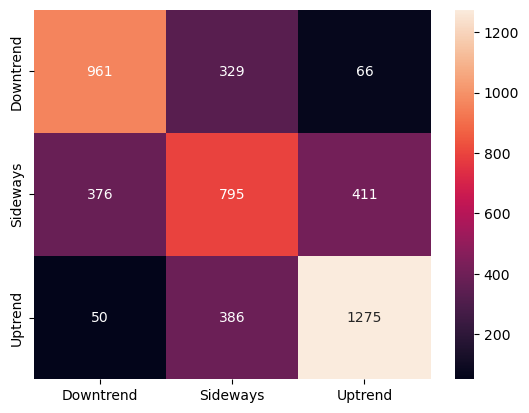

In [16]:
sns.heatmap(matrix, annot=True, fmt="g", xticklabels=['Downtrend', 'Sideways', 'Uptrend'],
            yticklabels=['Downtrend', 'Sideways', 'Uptrend'])

**Insight:**

**1.** Class 0 — Downtrend

Precision: 0.69 → when model predicts Downtrend, it's right 69% of the time

Recall: 0.71 → model able to capture 71% of actual downtrends

Very stable, strong performance

**2.** Class 1 — Sideways

Precision: 0.53

Recall: 0.50

Hardest class to detect as sideways markets have noisy, overlapping signals

**3.** Class 2 — Uptrend

Precision: 0.73

Recall: 0.75

Best-performing class. Uptrends are cleaner and more persistent


**In summary**

Logreg model is good at trend regimes (Up & Down) and weaker on Sideways.

#### Save logreg model

In [17]:
from joblib import dump

dump(logreg, "logistic_regression_model.pkl")

print("Model saved successfully as logistic_regression_model.pkl")

Model saved successfully as logistic_regression_model.pkl


#### Save preprocessed data

In [19]:
# Convert scaled columns to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns)

X_train_scaled.to_csv("X_train_scaled.csv", index=False)
X_test_scaled.to_csv("X_test_scaled.csv", index=False)


pd.Series(y_train_enc, name="target").to_csv("y_train_enc.csv", index=False)
pd.Series(y_test_enc,  name="target").to_csv("y_test_enc.csv",  index=False)

# check
print("✅ Saved y_train_enc and y_test_enc successfully!")

✅ Saved y_train_enc and y_test_enc successfully!


### Summary Analysis

## Accuracy 

Out of all **4,650 test samples**, only about **65%** were classified correctly. The result is better than random guessing for 3 classes (random chance ≈ 33%). Which suggests baseline model is learning something, but it’s still a bit confused.

## Confusin Matrix

For Actual Class 0: Only **960** were correctly predicted as 0 (recall = 71%)

For Actual Class 1: **792** correctly predicted as 1 (recall = 50%)

For Actual Class 2: **1278** correctly predicted (recall = 75%)

Insummary the baseline model confused class **0** for **1** and class **1** for **2** often.